# Multivariate Time Series Forecasting with LSTM

### Import Data

In [13]:
import pickle

model_file_path = './data/featurized_market_data.p'

with open(model_file_path, 'rb') as fp:
    featurized_market_data = pickle.load(fp)

### Import Dependencies

In [14]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

import pandas as pd
from matplotlib import pyplot as plt

### Prepare Data

In [15]:
# Separate time from the rest of the data.
pair_name = 'DOGE_BTC'
features = featurized_market_data[pair_name].dropna().set_index('time')

In [16]:
# Scale the data.
## LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized.
scaler = StandardScaler()
scaler = scaler.fit(features)
features_scaled = scaler.transform(features)

In [17]:
# Prepare training and prediction sliding windowed buckets.
features_current_past = []
features_future = []

# Count of steps to forecast into the future.
n_future_step_count = 1
# Count of steps to consider historically including the current step.
n_past_step_count_inc_current = 24
column_index_to_predict = 3

for i in range(n_past_step_count_inc_current, len(features_scaled) - n_future_step_count + 1):
    features_current_past.append(features_scaled[i - n_past_step_count_inc_current : i])
    features_future.append(features_scaled[i + n_future_step_count - 1 : i + n_future_step_count, column_index_to_predict])
    
features_current_past, features_future = np.array(features_current_past), np.array(features_future)

In [18]:
print(f'Past Window Shape: {features_current_past.shape}')
print(f'Future Window Shape: {features_future.shape}')

Past Window Shape: (20001, 24, 35)
Future Window Shape: (20001, 1)


In [19]:
index_to_inspect = 0
# -1 takes the last record in each windows (the current one of that window). Anything apart from -1 would be historical records for context / experience replay.
most_recent_features = features_current_past[index_to_inspect + 1][-1]

assert features_future[index_to_inspect] == most_recent_features[column_index_to_predict], 'The first future price should be the same as the following current price for the prediction column.'

### Setup Network

In [20]:
model = Sequential()
model.add(LSTM(128, activation='relu', recurrent_dropout=0.1, input_shape=(features_current_past.shape[1], features_current_past.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', recurrent_dropout=0.1, return_sequences=True))
model.add(LSTM(32, activation='relu', recurrent_dropout=0.1, return_sequences=False))
model.add(Dense(features_future.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 128)           83968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 64)            49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 145,825
Trainable params: 145,825
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [21]:
history = model.fit(features_current_past, features_future, epochs=50, batch_size=n_past_step_count_inc_current, validation_split=0.1, verbose=1)

Epoch 1/50
750/750 [==============================] - 38s 44ms/step - loss: 0.0184 - val_loss: 0.0040
Epoch 2/50
750/750 [==============================] - 39s 52ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 3/50
750/750 [==============================] - 42s 56ms/step - loss: 0.0032 - val_loss: 0.0049
Epoch 4/50
750/750 [==============================] - 38s 51ms/step - loss: 0.0030 - val_loss: 0.0063
Epoch 5/50
750/750 [==============================] - 33s 43ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 6/50
750/750 [==============================] - 40s 54ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 7/50
750/750 [==============================] - 39s 52ms/step - loss: 0.0020 - val_loss: 0.0121
Epoch 8/50
750/750 [==============================] - 34s 45ms/step - loss: 0.0022 - val_loss: 0.0137
Epoch 9/50
750/750 [==============================] - 31s 41ms/step - loss: 0.0019 - val_loss: 0.0104
Epoch 10/50
750/750 [==============================] - 31s 41ms/step - loss: 0.002

### Visualize Results

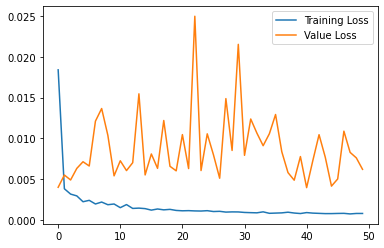

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Value Loss')
plt.legend()

### Make a Prediction

In [23]:
features_current_past[24-n_past_step_count_inc_current:24+1].shape

(25, 24, 35)

In [24]:
forecast_record_count = 24
forecast_frequency = '1h'
forecast = model.predict(features_current_past[-n_past_step_count_inc_current:])
forecast_period_dates = pd.date_range(list(features.index)[-1], periods=forecast_record_count, freq=forecast_frequency).tolist()

In [32]:
historical_steps_to_visualize = 48
historical_data = features.tail(historical_steps_to_visualize)

In [33]:
# Perform inverse scaling.
shaped_forecast = np.repeat(forecast, features.shape[1], axis=-1)
scaled_forecasts = scaler.inverse_transform(shaped_forecast)[:, column_index_to_predict]
forecast_df = pd.DataFrame({ 'time': np.array(forecast_period_dates), 'close': np.array(scaled_forecasts) }).set_index('time')

ValueError: All arrays must be of the same length

In [34]:
predictions = []

for window in features_current_past[-historical_steps_to_visualize:]:
    prediction_windows = []
    prediction_windows.append(window)
    prediction_windows = np.array(prediction_windows)
    forecast = model.predict(prediction_windows)
    shaped_forecast = np.repeat(forecast, features.shape[1], axis=-1)
    scaled_forecast = scaler.inverse_transform(shaped_forecast)[:, column_index_to_predict]
    predictions.append(scaled_forecast[0])

In [35]:
historical_data_with_predictions = historical_data.copy()
historical_data_with_predictions['predicted'] = predictions

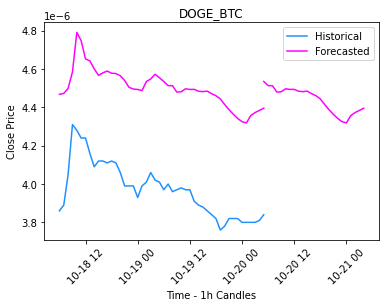

In [36]:
plt.title(pair_name)
plt.plot(historical_data_with_predictions['close'], label='Historical', color='dodgerblue')
plt.plot(historical_data_with_predictions['predicted'], color='magenta')
plt.plot(forecast_df['close'], label='Forecasted', color='magenta')
plt.xlabel('Time - 1h Candles')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()

### References
- [Documentation](https://timeseriestransformer.readthedocs.io/en/latest/README.html)

### Reading Material
- https://www.hindawi.com/journals/complexity/2020/6622927/
- https://timeseriestransformer.readthedocs.io/en/latest/README.html
- http://smo.sogang.ac.kr/doc/bellman.pdf
- http://www.it.uu.se/edu/course/homepage/aism/st11/MDPApplications3.pdf
- https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf